In [169]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib as plt
from datetime import date

In [170]:
data = pd.read_csv('../data/dax_indicator_2000_2024.csv')

In [171]:
data.drop('Date', axis=1, inplace=True)
data.head()

,open,high,low,close,volumen,direction_num,direction,ma_7,ma_21,ma_200
0,1284.510010,1284.510010,1284.510010,1284.510010,0,0.0,0,1271.230015,1255.598586,1108.528152
1,1282.750000,1282.750000,1282.750000,1282.750000,0,0.0,0,1274.825736,1258.144775,1109.915952
2,1299.589966,1299.589966,1299.589966,1299.589966,0,0.0,0,1279.758580,1260.579061,1111.631451
3,1309.229980,1309.229980,1309.229980,1309.229980,0,0.0,0,1283.409999,1263.730963,1113.197101
4,1288.439941,1288.439941,1288.439941,1288.439941,0,0.0,0,1285.255702,1265.190005,1114.609251


# X y validation Split

In [172]:
y = data[['direction']]
X = data.drop(['direction','direction_num','open','high','low','close'],axis=1)

In [173]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

In [174]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42, shuffle=False)

In [175]:
X_train_num = X_train.select_dtypes(np.number)
#X_train_cat = X_train.select_dtypes(object)
X_test_num = X_test.select_dtypes(np.number)
#X_test_cat = X_test.select_dtypes(object)
X_val_num = X_val.select_dtypes(np.number)
#X_val_cat = X_val.select_dtypes(object)


In [176]:
#X_train , X_test, X_val

# One Hot Encoder

# Transformer

In [177]:
for col in X_test_num.columns:
    print("Skewness from {} : {}".format(col,round(X_test_num[col].skew(),2)))

Skewness from volumen : 1.91
Skewness from ma_7 : -0.3
Skewness from ma_21 : -0.29
Skewness from ma_200 : -0.21


In [178]:
from sklearn.preprocessing import PowerTransformer

transformer = PowerTransformer(standardize=True)
transformer.fit(X_train_num) 

path = "./"
filename = "power_transformer_x.pkl"
with open(path+filename, "wb") as file:
    pickle.dump(transformer, file)

X_train_transformed = transformer.transform(X_train_num)
X_test_transformed = transformer.transform(X_test_num)
X_val_transformed = transformer.transform(X_val_num)

X_train_num_transformed_df = pd.DataFrame(X_train_transformed, columns=X_train_num.columns, index=X_train_num.index)
X_test_num_transformed_df  = pd.DataFrame(X_test_transformed,  columns=X_test_num.columns, index=X_test_num.index)
X_val_num_transformed_df = pd.DataFrame(X_val_transformed, columns=X_val_num.columns, index=X_val_num.index)

In [179]:
X_train_treated_df = X_train_num_transformed_df 
X_test_treated_df = X_test_num_transformed_df
X_val_treated_df = X_val_num_transformed_df 

#adding cat later 

In [180]:
for col in X_train_num_transformed_df.columns:
    print("Skewness from {} : {}".format(col,round(X_train_num_transformed_df[col].skew(),2)))

Skewness from volumen : 0.55
Skewness from ma_7 : 0.02
Skewness from ma_21 : 0.02
Skewness from ma_200 : 0.02


# Scaler X

In [181]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train_treated_df)

path = "./"
filename = "min_max_scaler_x.pkl"
with open(path+filename, "wb") as file:
    pickle.dump(scaler, file)

X_train_scaled = scaler.transform(X_train_treated_df)
X_test_scaled  = scaler.transform(X_test_treated_df)
X_val_scaled  = scaler.transform(X_val_treated_df)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_treated_df.columns)
X_test_scaled_df  = pd.DataFrame(X_test_scaled,  columns=X_test_treated_df.columns)
X_val_scaled_df  = pd.DataFrame(X_val_scaled,  columns=X_val_treated_df.columns)

# Logistic Regression

In [182]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, f1_score, cohen_kappa_score
from sklearn.linear_model import LogisticRegression

In [183]:
classification = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr')

classification.fit(X_train_scaled_df, y_train)

C:\Users\schue\IronHack\Bootcamp\Week_9\Final_project\proj_env\Lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(multi_class='ovr', random_state=0)

In [184]:
y_train_pred = classification.predict(X_train_scaled_df)
y_test_pred  = classification.predict(X_test_scaled_df)
y_val_pred  = classification.predict(X_val_scaled_df)

# Results

##  Confusion Matrix Train Set

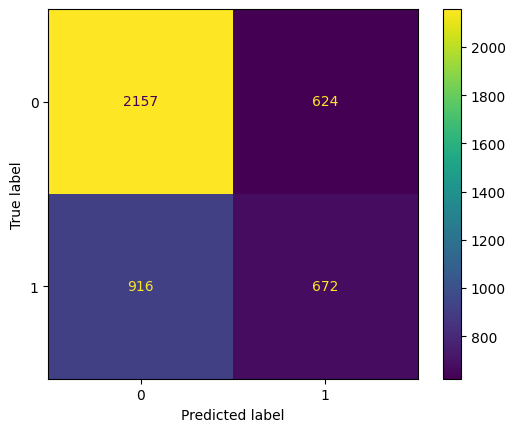

In [185]:
cm_train = confusion_matrix(y_train, y_train_pred)
cm_train
disp = ConfusionMatrixDisplay(cm_train, display_labels=classification.classes_);
disp.plot()

## Confusion Matrix Test Set

[[  6 869]
 [ 10 988]]


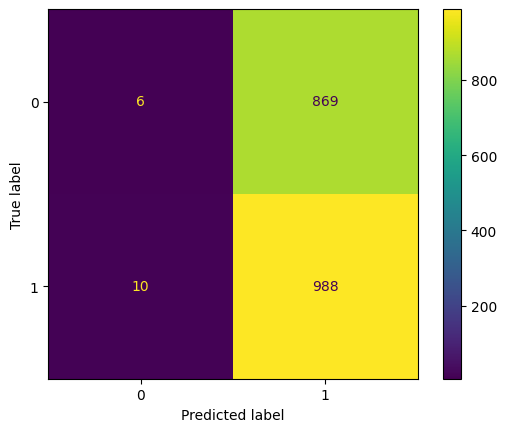

In [186]:
cm_test = confusion_matrix(y_test, y_test_pred)
print(cm_test)
disp = ConfusionMatrixDisplay(cm_test,display_labels=classification.classes_);
disp.plot()

## Confusion Matrix Validation Set

[[   0 1277]
 [   0 1399]]


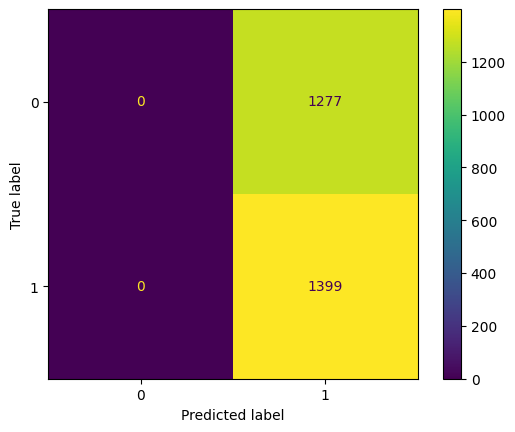

In [187]:
cm_test = confusion_matrix(y_val, y_val_pred)
print(cm_test)
disp = ConfusionMatrixDisplay(cm_test,display_labels=classification.classes_);
disp.plot()

## Error Matrix

In [188]:
error_metric = pd.DataFrame({"Train":[accuracy_score(y_train, y_train_pred),f1_score(y_train,y_train_pred),
                                recall_score(y_train,y_train_pred),precision_score(y_train, y_train_pred),
                                cohen_kappa_score(y_train, y_train_pred)],
                                "Test":[accuracy_score(y_test, y_test_pred),f1_score(y_test,y_test_pred),
                                recall_score(y_test,  y_test_pred),precision_score(y_test, y_test_pred),
                                cohen_kappa_score(y_test, y_test_pred)],
                                "Val":[accuracy_score(y_val, y_val_pred),f1_score(y_val,y_val_pred),
                                recall_score(y_val,  y_val_pred),precision_score(y_val, y_val_pred),
                                cohen_kappa_score(y_val, y_val_pred)]},
                                index=["accuracy","F1","recall","precission","kappa"])

In [189]:
error_metric

,Train,Test,Val
accuracy,0.647517,0.530699,0.522795
F1,0.466019,0.692119,0.686626
recall,0.423174,0.989980,1.000000
precission,0.518519,0.532041,0.522795
kappa,0.206957,-0.003367,0.000000


# Export

In [190]:
today = date.today()
model_name = 'logistic_regression'

In [191]:
error_metric.to_csv('../data/error_metric_{}_{}.csv'.format(model_name,today))